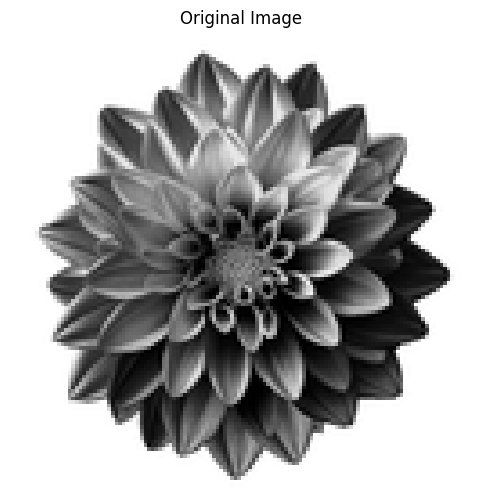

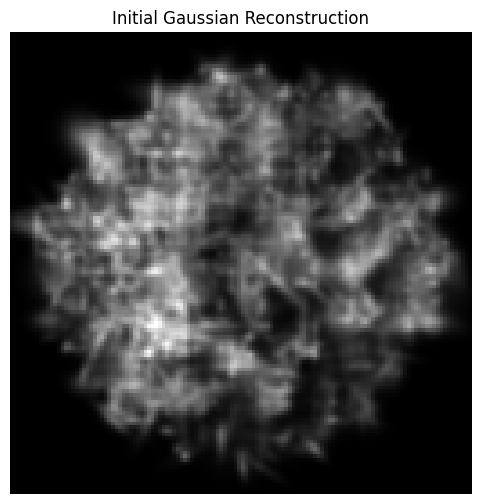

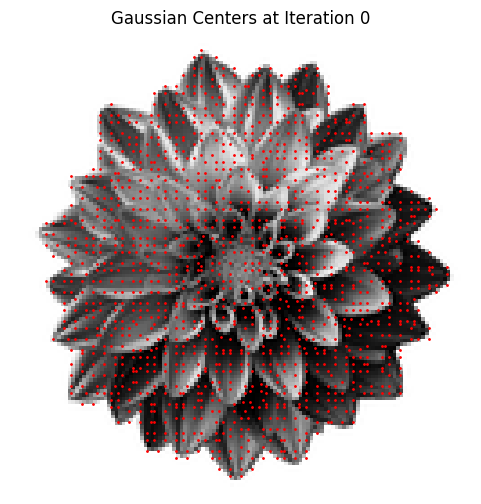

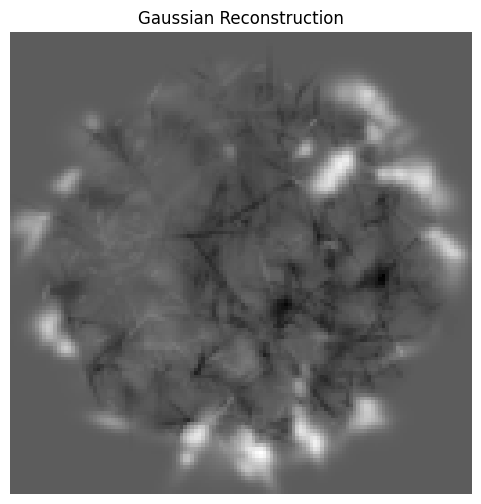

Iteration 0/300, Loss: 0.7902178764343262, LR: 0.5
Iteration 10/300, Loss: 0.16145546734333038, LR: 0.5
Iteration 20/300, Loss: 0.03262544423341751, LR: 0.5
Iteration 30/300, Loss: 0.016359610483050346, LR: 0.5
Iteration 40/300, Loss: 0.009700452908873558, LR: 0.5


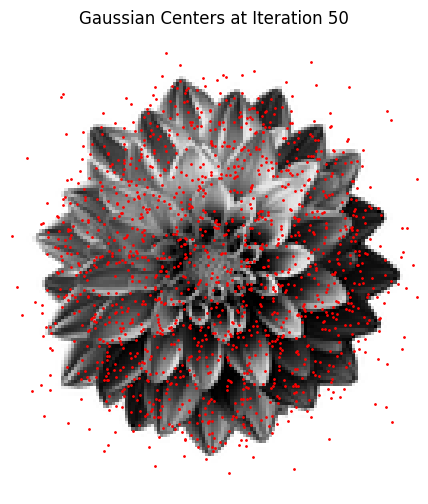

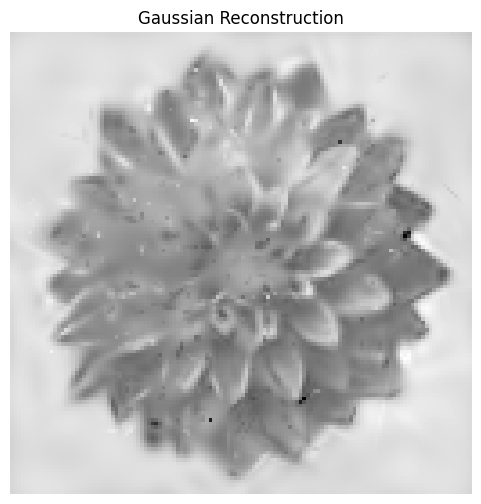

Iteration 50/300, Loss: 0.0078049818985164165, LR: 0.5
Iteration 60/300, Loss: 0.004493595100939274, LR: 0.5
Iteration 70/300, Loss: 0.004910121206194162, LR: 0.5
Iteration 80/300, Loss: 0.004762168042361736, LR: 0.5
Iteration 90/300, Loss: 0.0027556235436350107, LR: 0.5


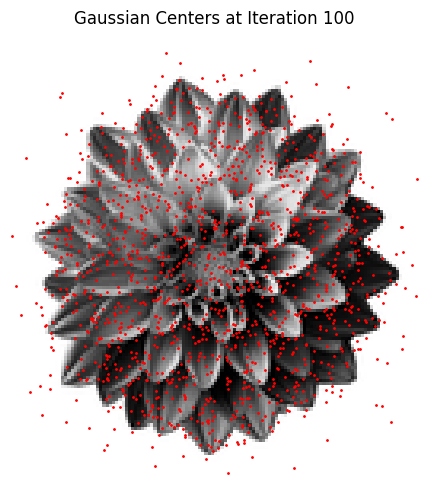

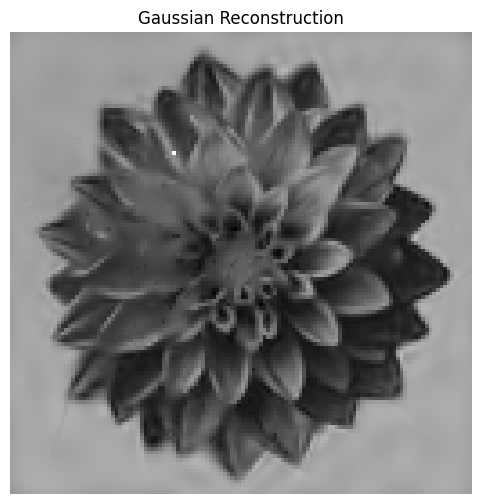

Iteration 100/300, Loss: 0.00530656985938549, LR: 0.35
Iteration 110/300, Loss: 0.0023867764975875616, LR: 0.35
Iteration 120/300, Loss: 0.0017674885457381606, LR: 0.35
Iteration 130/300, Loss: 0.0015785153955221176, LR: 0.35
Iteration 140/300, Loss: 0.0014192535309121013, LR: 0.35


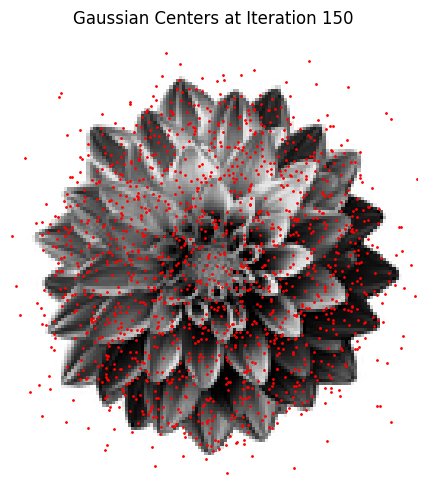

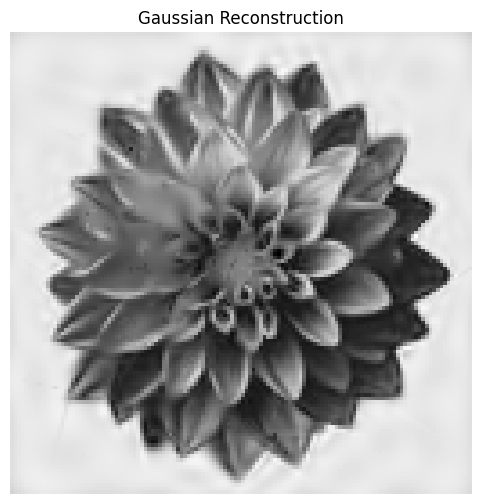

Iteration 150/300, Loss: 0.0013426430523395538, LR: 0.35
Iteration 160/300, Loss: 0.001259988872334361, LR: 0.35
Iteration 170/300, Loss: 0.0012305567506700754, LR: 0.35
Iteration 180/300, Loss: 0.0020077526569366455, LR: 0.35
Iteration 190/300, Loss: 0.0013281942810863256, LR: 0.35


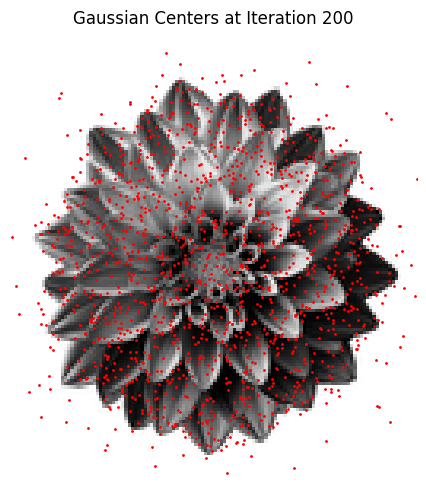

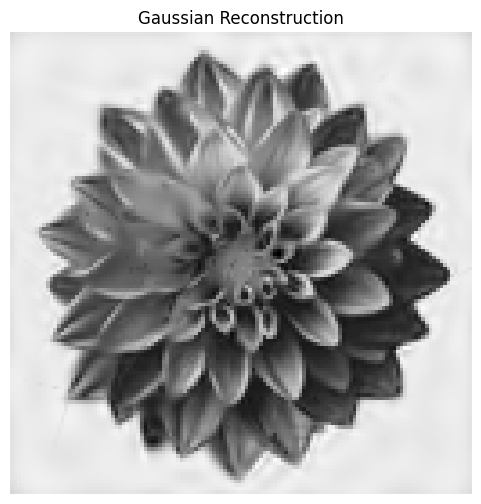

Iteration 200/300, Loss: 0.0012096292339265347, LR: 0.24499999999999997
Iteration 210/300, Loss: 0.0010848197853192687, LR: 0.24499999999999997
Iteration 220/300, Loss: 0.0010257824324071407, LR: 0.24499999999999997
Iteration 230/300, Loss: 0.0009889646898955107, LR: 0.24499999999999997
Iteration 240/300, Loss: 0.0009591951966285706, LR: 0.24499999999999997


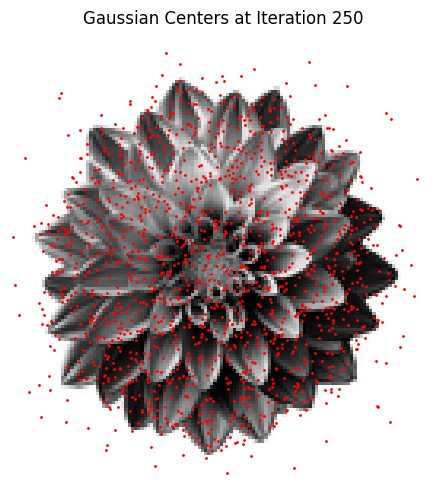

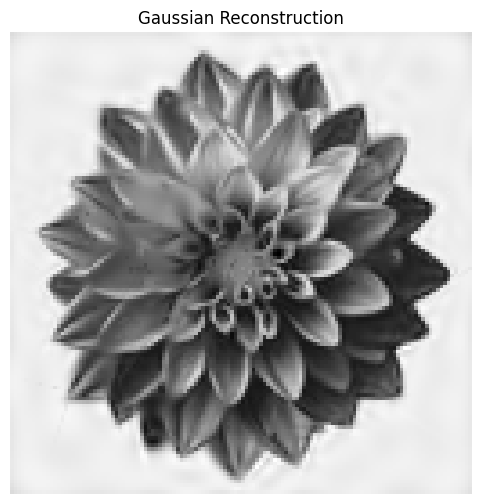

Iteration 250/300, Loss: 0.0009325246792286634, LR: 0.24499999999999997
Iteration 260/300, Loss: 0.0009135090513154864, LR: 0.24499999999999997
Iteration 270/300, Loss: 0.0009016389376483858, LR: 0.24499999999999997
Iteration 280/300, Loss: 0.0008933505741879344, LR: 0.24499999999999997
Iteration 290/300, Loss: 0.0008643629844300449, LR: 0.24499999999999997


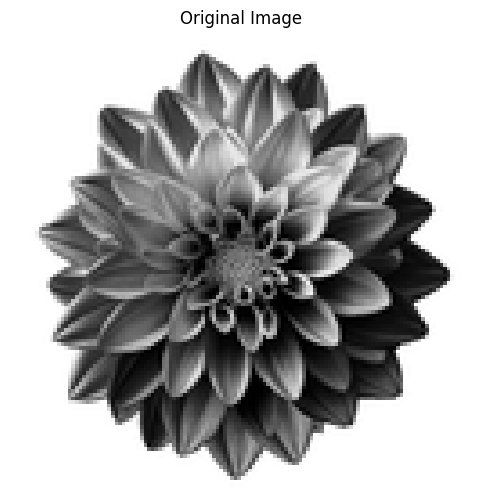

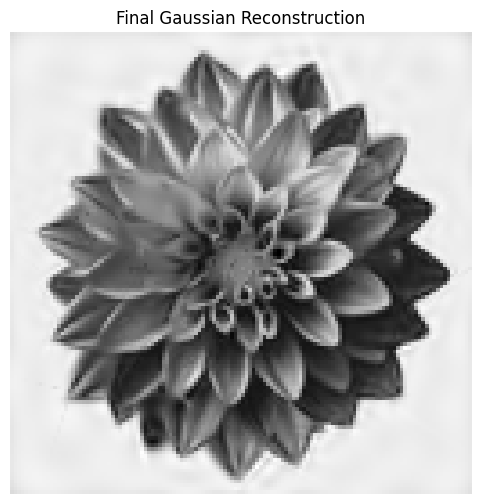

In [30]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and normalize the image
image_path = '/home/justin/Pictures/purple-flower.png'
image = Image.open(image_path).convert('L')

desired_size = (128, 128)  # Desired resolution
image = image.resize(desired_size, Image.LANCZOS)

img_np = np.array(image) / 255.0
img_tensor = torch.tensor(img_np).float().cuda()
# img_tensor = img_tensor.clamp(0,1)
# img_tensor = torch.logit(img_tensor, eps=1e-4)/1e1  # Logit transform to normalize the image
# print(img_tensor)

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(img_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

def validate_params(params):
    """
    Check if the parameters contain NaNs or extreme values.
    """
    if torch.isnan(params).any():
        raise ValueError("NaN value detected in parameters.")
    if torch.max(torch.abs(params)) > 1e5:
        raise ValueError("Extreme value detected in parameters.")
    
# Define the 2D Gaussian function with a color intensity parameter and rotation angle
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle):
    # Calculate the centered coordinates
    x_centered = x - mu_x
    y_centered = y - mu_y
    
    # Rotate the coordinates
    x_rot = x_centered * torch.cos(rotation_angle) - y_centered * torch.sin(rotation_angle)
    y_rot = x_centered * torch.sin(rotation_angle) + y_centered * torch.cos(rotation_angle)
    
    exponent = -((x_rot**2) / (2*sigma_x**2) + (y_rot**2) / (2*sigma_y**2))
    # print(color_intensity)
    return (torch.exp(exponent)) * color_intensity

# Model the image using a set of rotated Gaussians
def model_image(params, shape):
    x = torch.linspace(0, shape[1] - 1, shape[1]).cuda()
    y = torch.linspace(0, shape[0] - 1, shape[0]).cuda()
    x, y = torch.meshgrid(x, y)
    model = torch.zeros_like(x)
    # print("params max", torch.max(params))
    # print("params min", torch.min(params))
    # validate_params(params)
    for i in range(0, len(params), 7): 
        mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle, _ = params[i:i+7]
        model += gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle)
    
    return model

# Mean squared error loss function
def mse_loss(params):
    model = model_image(params, img_tensor.shape)
    # print("model", model)
    # print("img tensor", img_tensor)
    loss = torch.mean((model - img_tensor)**2)
    return loss

# Initialization using grid approach and sampling the image
num_gaussians = 2500
grid_size = int(np.sqrt(num_gaussians))
params = []
image_height, image_width = img_tensor.shape

for i in range(grid_size):
    for j in range(grid_size):
        # Calculate the coordinates within the image
        x_coord = (i * image_width) // grid_size
        y_coord = (j * image_height) // grid_size
        if img_tensor[y_coord, x_coord] > .9:
            continue
        
        # Sample the color intensity from the image at the calculated coordinates
        color_intensity = img_tensor[y_coord, x_coord]
        # print(color_intensity)
        
        mu_x = torch.tensor(x_coord).float().cuda()
        mu_y = torch.tensor(y_coord).float().cuda()
        sigma_x = torch.randn(1).mul(2).add(1).clamp(1, 20).cuda()
        sigma_y = torch.randn(1).mul(2).add(1).clamp(1, 20).cuda()
        rotation_angle = torch.rand(1).mul(2 * np.pi).cuda()  # Random rotation angle
        
        params.extend([mu_x.item(), mu_y.item(), sigma_x.item(), sigma_y.item(), color_intensity.item(), rotation_angle.item(), 0.0])

params = torch.tensor(params, device='cuda').requires_grad_()
optimizer = optim.Adam([params], lr=0.5)  # Slightly increase learning rate to observe effects
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

# Display the initial Gaussian-based reconstruction
initial_model = model_image(params, img_tensor.shape).cpu().detach().numpy()
plt.figure(figsize=(6, 6))
plt.imshow(initial_model, cmap='gray')
plt.title("Initial Gaussian Reconstruction")
plt.axis('off')
plt.show()

# Optimize with scheduler step
iterations = 300
display_interval = 50  # Display the Gaussian centers every 100 iterations

for iteration in range(iterations):
    optimizer.zero_grad()
    loss = mse_loss(params)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if iteration % display_interval == 0:
        # Display Gaussian centers intermittently
        plt.figure(figsize=(6, 6))
        plt.imshow(img_np, cmap='gray')
        plt.scatter(params[::7].cpu().detach().numpy(), params[1::7].cpu().detach().numpy(), color='red', s=1)
        plt.title(f"Gaussian Centers at Iteration {iteration}")
        plt.axis('off')
        plt.show()

        model = model_image(params, img_tensor.shape).cpu().detach().numpy()
        plt.figure(figsize=(6, 6))
        plt.imshow(model, cmap='gray')
        plt.title("Gaussian Reconstruction")
        plt.axis('off')
        plt.show()
    if iteration % 10 == 0:
        print(f"Iteration {iteration}/{iterations}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()[0]}")

# Display result
result = model_image(params, img_tensor.shape).cpu().detach().numpy()
plt.figure(figsize=(6, 6))
plt.imshow(img_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()
plt.figure(figsize=(6, 6))
plt.imshow(result, cmap='gray')
plt.title("Final Gaussian Reconstruction")
plt.axis('off')
plt.show()